##**‼️That's important to change the Runtime in Google Colab, on the top drop-down menu select Runtime, then select Change runtime type. Under Hardware accelerator, select T4 GPU , then click Save**‼️

In [1]:
!pip install transformers

In [ ]:
# импорт необходимых библиотек

import pandas as pd # табличное представление и чтение|запись csv
import numpy as np # векторы, матрицы
import random # случайный генератор
import time # измерение времени
from tqdm import tqdm # прогресс-бар

# предобработка текста
import nltk
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # токенизация по словам
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_curve, auc # метрики классификации
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re # удаление знаков препинания через регулярное выражение

# нейронные слои
import torch
import torch.nn as nn # настройка нейросети (класс родитель)
import torch.optim as optim # оптимизация
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler # объекты настройки
import torch.nn.functional as F # функция softmax

# трансформеры, предобученные
from transformers import BertModel # класс модели BERT
from transformers import get_linear_schedule_with_warmup # оптимизатор и загрузчик
from transformers import BertTokenizer, BertForSequenceClassification # Токенизатор, классификатор

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report # метрики классификации

In [9]:
# фиксируем сиды для воспроизводимости
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df_original = pd.read_csv('/content/drive/MyDrive/Business_hse/HW_2/IMDB.csv')

Mounted at /content/drive


In [4]:
df_original['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [5]:
df_original['sentiment'].replace('positive', 1, inplace = True)
df_original['sentiment'].replace('negative', 0, inplace = True)

/tmp/ipython-input-3562699266.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_original['sentiment'].replace('positive', 1, inplace = True)
/tmp/ipython-input-3562699266.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [6]:
df_original.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
df_original.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [8]:
# вспомогательные загрузки
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stop_words = set(stopwords.words('english'))
html_regex = re.compile(r'<.*?>')
non_letter_regex = re.compile(r'[^a-zA-Z ]+')

In [11]:
df_original['review'] = df_original['review'].astype(str).apply(
    lambda text: ' '.join([
        w.lower() for w in re.sub(non_letter_regex, ' ', re.sub(html_regex, ' ', text)).split()
        if w.lower() not in stop_words
    ])
)



In [12]:
df_original['review'] = df_original['review'].str.replace(' ', '_')

In [13]:
df_original.head()

,review,sentiment
0,one_reviewers_mentioned_watching_oz_episode_ho...,1
1,wonderful_little_production_filming_technique_...,1
2,thought_wonderful_way_spend_time_hot_summer_we...,1
3,basically_family_little_boy_jake_thinks_zombie...,0
4,petter_mattei_love_time_money_visually_stunnin...,1


In [14]:
BERT_HUGGING_MODEL = 'bert-base-uncased'

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df_original['review'].values,
    df_original['sentiment'].values,
    test_size=0.3,
    random_state=seed,
    stratify=df_original['sentiment'].values,
)

len(X_train), len(X_test), sum(y_train)/len(y_train)


(35000, 15000, np.float64(0.5))

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_HUGGING_MODEL)
model = BertForSequenceClassification.from_pretrained(
    BERT_HUGGING_MODEL,
    num_labels=2
)

model.to(DEVICE)

In [27]:
MAX_LEN = 128

train_encodings = tokenizer(
    list(X_train),
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

test_encodings = tokenizer(
    list(X_test),
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

train_labels = torch.tensor(y_train, dtype=torch.long)
test_labels = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

len(train_dataset), len(test_dataset)


(35000, 15000)

In [28]:
# DataLoader'ы
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader)


(2188, 938)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 2
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps,
)

total_steps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


4376

In [30]:
EPOCHS = 2
best_state = None
best_f1 = 0

for epoch in range(EPOCHS):
    print(f'\n===== Эпоха {epoch+1}/{EPOCHS} =====')
    # train
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc='train'):
        b_input_ids, b_attn_mask, b_labels = [t.to(DEVICE) for t in batch]
        model.zero_grad()
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attn_mask,
            labels=b_labels
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Средний loss на train: {avg_train_loss:.4f}')

    # eval
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='eval'):
            b_input_ids, b_attn_mask, b_labels = [t.to(DEVICE) for t in batch]
            outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
            logits = outputs.logits
            all_logits.append(logits.cpu())
            all_labels.append(b_labels.cpu())
    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    preds = torch.argmax(logits, dim=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    report = classification_report(labels, preds, target_names=['negative', 'positive'], digits=4)
    print(report)

    if f1 > best_f1:
        best_f1 = f1
        best_state = model.state_dict()
        print(f'Новая лучшая F1: {best_f1:.4f}')

if best_state:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), 'bert_imdb_best.pt')
    print('Сохранили модель bert_imdb_best.pt')



===== Эпоха 1/2 =====


train: 100%|██████████| 2188/2188 [13:07<00:00,  2.78it/s]


Средний loss на train: 0.4023


eval: 100%|██████████| 938/938 [01:50<00:00,  8.48it/s]


              precision    recall  f1-score   support

    negative     0.8625    0.8679    0.8652      7500
    positive     0.8670    0.8616    0.8643      7500

    accuracy                         0.8647     15000
   macro avg     0.8647    0.8647    0.8647     15000
weighted avg     0.8647    0.8647    0.8647     15000

Новая лучшая F1: 0.8643

===== Эпоха 2/2 =====


train: 100%|██████████| 2188/2188 [13:08<00:00,  2.78it/s]


Средний loss на train: 0.2493


eval: 100%|██████████| 938/938 [01:50<00:00,  8.51it/s]


              precision    recall  f1-score   support

    negative     0.8837    0.8615    0.8725      7500
    positive     0.8649    0.8867    0.8756      7500

    accuracy                         0.8741     15000
   macro avg     0.8743    0.8741    0.8740     15000
weighted avg     0.8743    0.8741    0.8740     15000

Новая лучшая F1: 0.8756
Сохранили модель bert_imdb_best.pt


##If you are not satisfied with result, you can change MAX_LEN to 256, with worse time performance, but with better Accuracy:

===== Эпоха 1/2 =====

train: 100%|██████████| 2188/2188 [25:05<00:00,  1.45it/s]

Средний loss на train: 0.3482

eval: 100%|██████████| 938/938 [03:24<00:00,  4.60it/s]
              
              precision    recall  f1-score   support

    negative     0.8948    0.9012    0.8980      7500
    positive     0.9005    0.8940    0.8972      7500

    accuracy                         0.8976     15000
   macro avg     0.8976    0.8976    0.8976     15000
weighted avg     0.8976    0.8976    0.8976     15000

Новая лучшая F1: 0.8972


<br>
===== Эпоха 2/2 =====

train: 100%|██████████| 2188/2188 [25:15<00:00,  1.44it/s]

Средний loss на train: 0.2034

eval: 100%|██████████| 938/938 [03:25<00:00,  4.57it/s]

              precision    recall  f1-score   support

    negative     0.9081    0.8984    0.9032      7500
    positive     0.8995    0.9091    0.9042      7500

    accuracy                         0.9037     15000
   macro avg     0.9038    0.9037    0.9037     15000
weighted avg     0.9038    0.9037    0.9037     15000

Новая лучшая F1: 0.9042

Сохранили модель bert_imdb_best.pt

##

In [23]:
model.eval()
all_logits = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='final eval'):
        b_input_ids, b_attn_mask, b_labels = [t.to(DEVICE) for t in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu())
        all_labels.append(b_labels.cpu())
logits = torch.cat(all_logits)
labels = torch.cat(all_labels)
preds = torch.argmax(logits, dim=1)

acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
print('Итоговые метрики на test:')
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

sample_text = "This movie was absolutely wonderful, great acting and story!"
encoded = tokenizer(
    [sample_text],
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
input_ids = encoded['input_ids'].to(DEVICE)
attn_mask = encoded['attention_mask'].to(DEVICE)

start = time.time()
with torch.no_grad():
    logits = model(input_ids, attention_mask=attn_mask).logits
elapsed = time.time() - start
probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
pred_label = int(np.argmax(probs))
print(f'Пример прогноза: label={pred_label} (prob_pos={probs[1]:.3f}), время {elapsed*1000:.2f} мс')


final eval: 100%|██████████| 938/938 [03:24<00:00,  4.58it/s]

Итоговые метрики на test:
Accuracy: 0.9037
Precision: 0.8995
Recall: 0.9091
F1: 0.9042
Пример прогноза: label=1 (prob_pos=0.995), время 38.64 мс


##With MAX_LEN = 256, the results will be:

final eval: 100%|██████████| 938/938 [03:24<00:00,  4.58it/s]
Итоговые метрики на test: <br>
Accuracy: 0.9037 <br>
Precision: 0.8995 <br>
Recall: 0.9091 <br>
F1: 0.9042 <br>
Пример прогноза: label=1 (prob_pos=0.995), время 38.64 мс

AUC: 0.9456


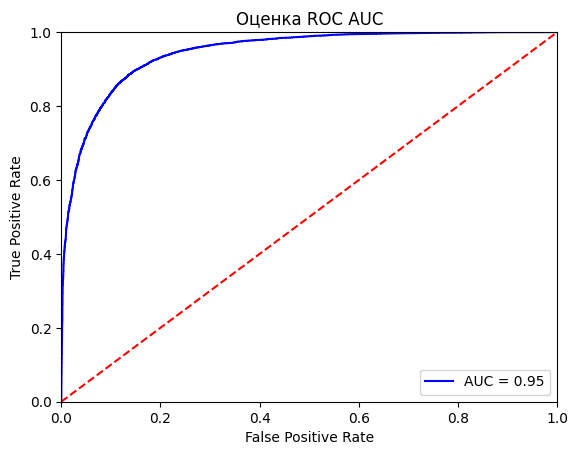

In [39]:
# построим ROC-кривую для наглядной оценки качества
probs = torch.softmax(logits, dim=1).cpu().numpy()[:, 1]
y_true = labels.cpu().numpy()

fpr, tpr, thresholds = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

plt.figure()
plt.title('Оценка ROC AUC')
plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

##

In [24]:
manual_examples = [
    "An absolute masterpiece, I will watch it again!",
    "Terrible plot and acting, I want my time back.",
    "Mediocre film but the soundtrack was nice.",
    "Loved every minute, brilliant performances.",
    "The pacing was awful and characters were annoying."
]

encoded = tokenizer(
    manual_examples,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
with torch.no_grad():
    logits = model(
        encoded['input_ids'].to(DEVICE),
        attention_mask=encoded['attention_mask'].to(DEVICE)
    ).logits
probs = torch.softmax(logits, dim=1).cpu().numpy()
preds = np.argmax(probs, axis=1)
for text, pred, prob in zip(manual_examples, preds, probs):
    print(f'[{"pos" if pred==1 else "neg"}] p_pos={prob[1]:.3f} | {text[:120]}')


[pos] p_pos=0.989 | An absolute masterpiece, I will watch it again!
[neg] p_pos=0.005 | Terrible plot and acting, I want my time back.
[neg] p_pos=0.255 | Mediocre film but the soundtrack was nice.
[pos] p_pos=0.994 | Loved every minute, brilliant performances.
[neg] p_pos=0.003 | The pacing was awful and characters were annoying.


## Выводы
- Подготовили данные: очистили тексты, сохранили баланс классов, токенизировали через BERT tokenizer с паддингом/обрезкой до 128 (256 if needed) токенов.
- Обучили `bert-base-uncased` с дополнительным линейным слоем на 2 класса; измеряем Accuracy/Precision/Recall/F1 на test, сохраняем лучший стейт.
- Инференс на одном отзыве занимает доли секунды; на ручных примерах модель различает явно положительные и отрицательные отзывы.
- При необходимости для стабильности метрик можно повторить train/test split с другим сидом (stratify=True) — код воспроизводим за счёт фиксированного сид-сета.
